# Yet another attempt to train a model that doesn't take ages
## Strategy here: first compute and save all spectrograms, then sample from spectrograms for training

### Imports

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import h5py

import tensorflow as tf
# Set logging level to avoid unnecessary messages
tf.get_logger().setLevel('ERROR')
# Set autograph verbosity to avoid unnecessary messages
tf.autograph.set_verbosity(0)

import keras
import tensorflow_io as tfio
import tensorflow_probability as tfp
import tensorflow_extra as tfe

import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

from pathlib import Path
import sys
import os
import time
import warnings
# suppress all warnings
warnings.filterwarnings("ignore")

XC_ROOTDIR = '../../data/' # directory to save data in
XC_DIR = 'test_dataset10' # subdirectory name of dataset

#tf.config.set_visible_devices([], 'GPU')

2024-07-09 10:56:33.516961: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Read data

In [2]:
df = pd.read_csv("../../data/dataset10.csv")
#df["fullfilename"] = "../" + df["fullfilename"]

### Configuration

In [3]:
class cfg:
    # random seed
    seed = 42

    # audio clip settings
    sr = 22050
    duration = 15 # the duration of the clips
    
    n_samples = duration*sr
    
    hop_length = 2048 # "stepsize" of the fft for the melspectrograms
    nfft = 4096 # windowsize of the fft for the melspectrograms
    n_mels = 128 # number of mel frequency bins
    fmax = sr/2 # maximum frequency in the melspectrograms
    input_dim = (n_mels, int(duration*sr//hop_length + 1))
    
    # training settings
    batch_size = 32
    n_epochs = 50
    
    # class labels/names
    names = list(np.unique(df.en))
    n_classes = len(names)
    labels = list(range(n_classes))
    label2name = dict(zip(labels, names))
    name2label = {v:k for k,v in label2name.items()}

# set random seed in keras
tf.keras.utils.set_random_seed(cfg.seed)

## Load all audios, compute and save spectrograms

### Functions to compute, save and load spectrogram

In [4]:
def compute_spec(filepath, sr=cfg.sr, duration=cfg.duration, nfft=cfg.nfft, hop_length=cfg.hop_length, n_mels=cfg.n_mels, fmax=cfg.fmax):
    audio, sr = librosa.load(filepath, sr = sr)
    # randomly pad clip if shorter
    if len(audio) < duration*sr:
        _ = np.zeros(duration*sr)
        rand_idx = np.random.randint(0, duration*sr-len(audio))
        _[rand_idx:rand_idx + len(audio)] = audio
        audio = _
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=nfft, hop_length=hop_length, n_mels=n_mels, fmin = 0, fmax=fmax)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    return log_mel_spectrogram

def save_spec_to_hdf5(spec, hdf5_path, name, compression="gzip", chunks=True):
    try:
        with h5py.File(hdf5_path, 'a') as f:  # Open in append mode
            f.create_dataset(name, data=spec, compression=compression, chunks=chunks)
    except Exception as e:
        print(f'Error saving spectrograms to {hdf5_path}: {e}')

In [5]:
def compute_and_save_spec(filepath, return_length = False):
    spec = compute_spec(filepath)
    name = Path(filepath).stem
    hdf5_path = os.path.dirname(filepath) + "/spectrograms.h5"
    save_spec_to_hdf5(spec, hdf5_path = hdf5_path, name = name)
    if return_length:
        return spec.shape[-1]

def load_spectrogram_slice(hdf5_path, name, start_row = 0, end_row =None, start_col = 0, end_col = None):
    with h5py.File(hdf5_path, 'r') as f:
        spectrogram_slice = f[name][start_row:end_row, start_col:end_col]
    return spectrogram_slice

In [6]:
spec = compute_spec(df.fullfilename.iloc[0])
spec.shape

(128, 3226)

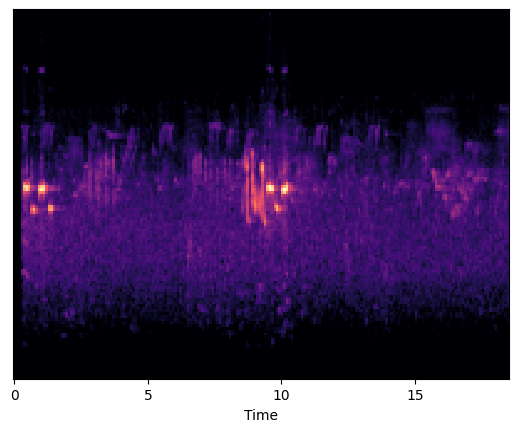

In [7]:
fig, ax = plt.subplots(1,1)
librosa.display.specshow(spec[:, 0:200], sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax)

In [8]:
path = df.fullfilename.iloc[0]
compute_and_save_spec(path)

Error saving spectrograms to ../../data/dataset10/Turdus merula_Common Blackbird/spectrograms.h5: Unable to synchronously create dataset (name already exists)


In [9]:
spec = load_spectrogram_slice(os.path.dirname(path) + "/spectrograms.h5", Path(path).stem)
spec.shape

(128, 3226)

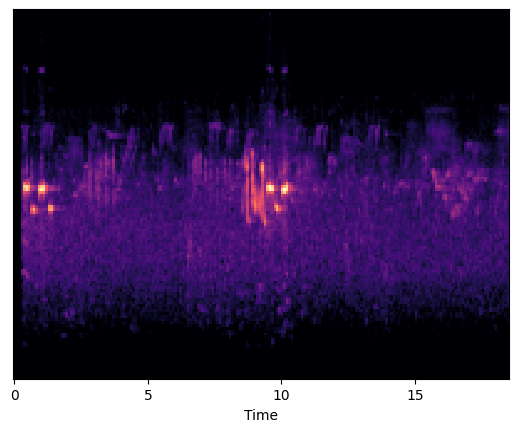

In [10]:
fig, ax = plt.subplots(1,1)
librosa.display.specshow(spec[:, 0:200], sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax)

### Compute and save spectrograms for all audios in the dataset

In [11]:
if not "spectrogram" in df.columns:
    df["spectrogram"] = None
if not "length_spectrogram" in df.columns:
    df["length_spectrogram"] = None
for i in tqdm(range(len(df))):
    filepath = df.fullfilename.iloc[i]
    if df.loc[i, "spectrogram"] is None:
        df.loc[i, "length_spectrogram"] = compute_and_save_spec(filepath, return_length = True)
        df.loc[i, "spectrogram"] = Path(filepath).stem


df.to_csv("../../data/dataset10.csv", index = False)

100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 37072.90it/s]


(128, 2866)


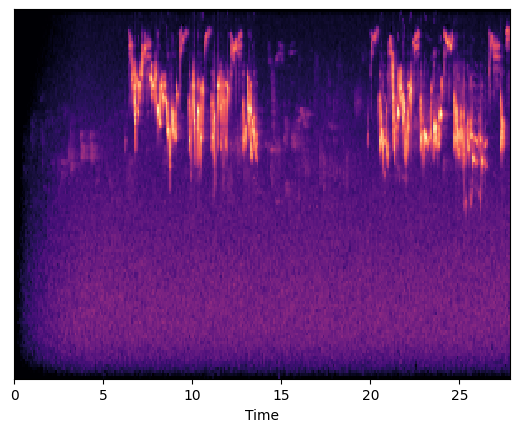

In [12]:
path = df.fullfilename.iloc[42]
spec = load_spectrogram_slice(os.path.dirname(path) + "/spectrograms.h5", Path(path).stem)
print(spec.shape)
fig, ax = plt.subplots(1,1)
librosa.display.specshow(spec[:, 0:300], sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax)

## Create data generator for training

### Helper functions

In [13]:
# Generates random integer # from https://www.kaggle.com/code/wengsilu/birdclef24pretraining
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)

# Generats random float
def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd

In [14]:
cfg.input_dim[1]

162

In [15]:
def load_random_spec_slice(df, ID):
    name = df.spectrogram.iloc[ID]
    hdf5_path = os.path.dirname(df.fullfilename.iloc[ID]) + "/spectrograms.h5"
    spec_length = df.length_spectrogram.iloc[ID]
    rdm = random_int(maxval= spec_length - cfg.input_dim[1])
    return load_spectrogram_slice(hdf5_path = hdf5_path, name = name, start_col = rdm, end_col = rdm + cfg.input_dim[1])

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, dataframe,
                 batch_size=cfg.batch_size, 
                 dim=cfg.input_dim,
                 n_channels =  1,
                 n_classes=cfg.n_classes, 
                 shuffle=True
                ):
        'Initialization'
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.dataframe = dataframe
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = load_random_spec_slice(self.dataframe, ID).reshape(*self.dim, self.n_channels)
            # Store class
            y[i] = cfg.name2label[df.en.iloc[ID]]
        X = X.reshape(len(X), *self.dim, self.n_channels)
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

2024-07-09 10:57:04.602598: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-09 10:57:04.607755: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-09 10:57:04.607977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-09 10:57:04.609098: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-09 10:57:04.609303: I external/local_xla/xla/stream_executor

(128, 162)
(128, 162)


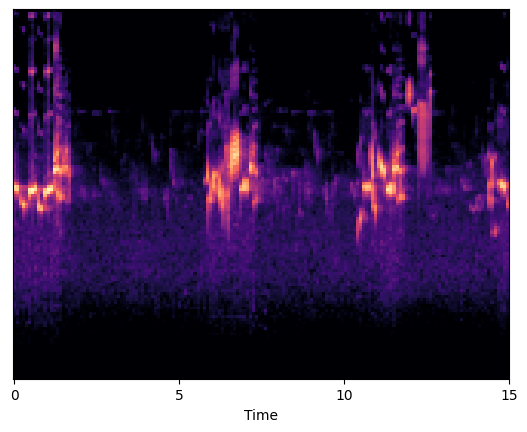

In [16]:
spec = load_random_spec_slice(df, ID = 0)
print(spec.shape)
fig, ax = plt.subplots(1,1)
librosa.display.specshow(spec, sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax);
print(cfg.input_dim)

## Build model

In [17]:
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input

zscore_layer = tfe.layers.ZScoreMinMax()

def build_model():
    inp = Input(shape=(*cfg.input_dim, 1))
    
    # Normalize
    x = zscore_layer(inp)
    
    # Base model
    x = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    x = Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(cfg.n_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=output, name = "Basemodel")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

### Test zscore_layer

In [18]:
specs = []
for i in tqdm(range(50)):
    specs.append(load_random_spec_slice(df, ID = i))
specs = np.array(specs)
print("Before zscore layer: ", specs.min(), specs.max())

print("After zscore layer: ", zscore_layer(specs).numpy().min(), zscore_layer(specs).numpy().max())


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.78it/s]


Before zscore layer:  -63.894543 39.862907
After zscore layer:  0.0 1.0


In [19]:
model = build_model()

Model: "Basemodel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 162, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z_score_min_max (ZScoreMinMax)  │ (None, 128, 162, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 160, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 78, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 74880)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,792,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,813,610 (18.36 MB)

 Trainable params: 4,813,610 (18.36 MB)

 Non-trainable params: 0 (0.00 B)

## Train validation split

In [20]:
from sklearn.model_selection import train_test_split

id_train, id_val, y_train, y_val = train_test_split(range(len(df)), df["en"].to_list(), test_size = 0.3, random_state = cfg.seed)

training_generator = DataGenerator(id_train, y_train, df)
validation_generator = DataGenerator(id_val, y_val, df)

In [22]:
hist = model.fit(training_generator, validation_data=validation_generator, verbose = 2, epochs = cfg.n_epochs)

Epoch 1/50


I0000 00:00:1720515466.961579   19514 service.cc:145] XLA service 0x7f1694962990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720515466.961654   19514 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2024-07-09 10:57:47.003699: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-09 10:57:47.240895: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1720515473.240004   19514 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 - 19s - 3s/step - accuracy: 0.1094 - loss: 2.4768 - val_accuracy: 0.1094 - val_loss: 2.3095
Epoch 2/50
6/6 - 8s - 1s/step - accuracy: 0.1042 - loss: 2.3046 - val_accuracy: 0.0625 - val_loss: 2.3118
Epoch 3/50
6/6 - 8s - 1s/step - accuracy: 0.1458 - loss: 2.2950 - val_accuracy: 0.0469 - val_loss: 2.3247
Epoch 4/50
6/6 - 7s - 1s/step - accuracy: 0.0938 - loss: 2.3010 - val_accuracy: 0.0312 - val_loss: 2.3147
Epoch 5/50
6/6 - 10s - 2s/step - accuracy: 0.1667 - loss: 2.2843 - val_accuracy: 0.0469 - val_loss: 2.3331
Epoch 6/50
6/6 - 6s - 1s/step - accuracy: 0.1354 - loss: 2.2861 - val_accuracy: 0.0938 - val_loss: 2.3295
Epoch 7/50
6/6 - 6s - 953ms/step - accuracy: 0.1719 - loss: 2.2729 - val_accuracy: 0.0625 - val_loss: 2.3499
Epoch 8/50
6/6 - 5s - 865ms/step - accuracy: 0.1354 - loss: 2.2627 - val_accuracy: 0.1250 - val_loss: 2.3254
Epoch 9/50
6/6 - 5s - 846ms/step - accuracy: 0.1771 - loss: 2.2657 - val_accuracy: 0.1250 - val_loss: 2.2837
Epoch 10/50
6/6 - 5s - 864ms/step - accuracy: 

In [23]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

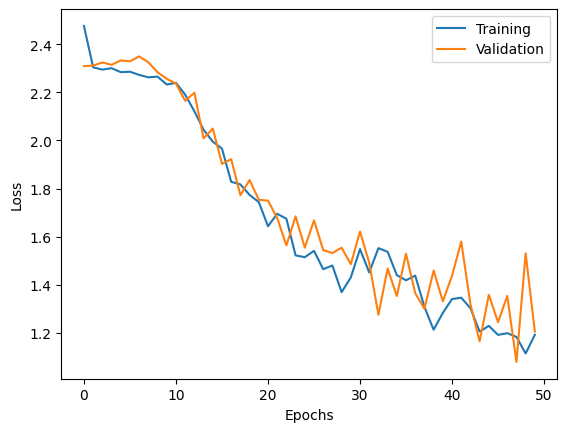

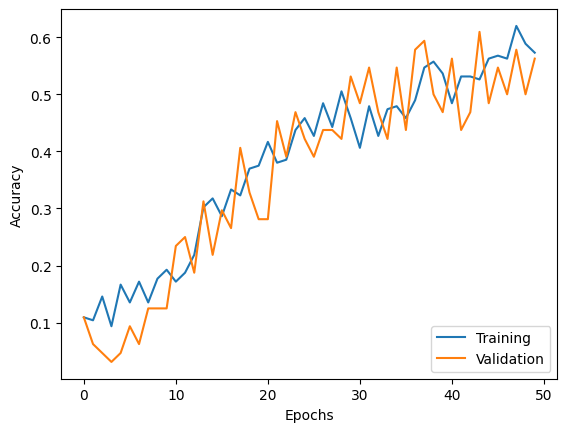

In [24]:
plot_history(hist)

### Train for another n_epochs

In [25]:
#hist2 = model.fit(training_generator, 
#                  validation_data=validation_generator,
#                  use_multiprocessing=True, verbose = 2, epochs = cfg.n_epochs)

In [26]:
#plot_history(hist2)

## Predict method

    -load spectrogram
    -divide into slices
    -pad last slice if long enough
    -predict slices
    -average prediction or smth.

In [27]:
spec = load_random_spec_slice(df, 269)

model.predict(spec.reshape(1, *spec.shape, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


array([[6.5354549e-04, 5.2000710e-04, 1.4040929e-05, 5.5696148e-07,
        9.4377220e-01, 5.4163441e-02, 5.1886900e-07, 8.6279272e-07,
        1.8605706e-06, 8.7285403e-04]], dtype=float32)

In [28]:
def pad_spectrogram(spec, shape = cfg.input_dim, random = False):
    _ = np.zeros(shape)
    if random:
        rdm = random_int(maxval=shape[1]-spec.shape[1])
        _[:,rdm: rdm + spec.shape[1]] = spec 
    else:
        _[:,:spec.shape[1]] = spec
    return _

In [29]:
ID = 0
name = df.spectrogram.iloc[ID]
hdf5_path = os.path.dirname(df.fullfilename.iloc[ID]) + "/spectrograms.h5"
spec_length = df.length_spectrogram.iloc[ID]
spec = load_spectrogram_slice(hdf5_path, name, start_row = 0, end_row =None, start_col = 0, end_col = None)
slices = []
for i in range(spec_length//cfg.input_dim[1]):
    slices.append(spec[:,i*cfg.input_dim[1]:(i+1)*cfg.input_dim[1]])
if spec_length%cfg.input_dim[1]/cfg.input_dim[1] > 5/cfg.duration: # consider last slice, only if it is longer than the shortest clips in the dataset 
    slices.append(pad_spectrogram(spec[:, (i+1)*cfg.input_dim[1]:None], random = True))
preds = model.predict(np.expand_dims(np.array(slices), axis = -1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step


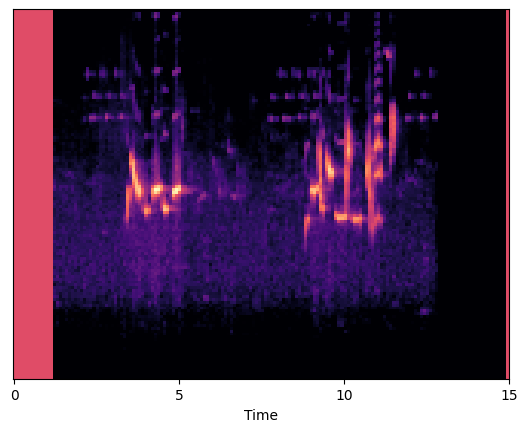

In [30]:
pad_spectrogram(slices[19]).shape

fig, ax = plt.subplots(1,1)
librosa.display.specshow(slices[19], sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax);

In [31]:
def predict_file(df, ID, model):
    name = df.spectrogram.iloc[ID]
    hdf5_path = os.path.dirname(df.fullfilename.iloc[ID]) + "/spectrograms.h5"
    spec_length = df.length_spectrogram.iloc[ID]
    spec = load_spectrogram_slice(hdf5_path, name)
    slices = []
    
    for i in range(spec_length//cfg.input_dim[1]):
        slices.append(spec[:,i*cfg.input_dim[1]:(i+1)*cfg.input_dim[1]])
    if spec_length%cfg.input_dim[1]/cfg.input_dim[1] > 5/cfg.duration:
        # consider last slice, only if it is longer than the shortest clips in the dataset 
        slices.append(pad_spectrogram(spec[:, (i+1)*cfg.input_dim[1]:None], random = True))
    
    preds = model.predict(np.expand_dims(np.array(slices), axis = -1))
    
    return np.mean(preds, axis = 0) # return mean prediction

In [32]:
preds = []
for i in tqdm(df.index):
    preds.append(predict_file(df, ID = i, model = model))

  0%|                                                                                           | 0/300 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|▎                                                                                  | 1/300 [00:00<00:35,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  1%|▊                                                                                  | 3/300 [00:00<00:26, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step


  2%|█▍                                                                                 | 5/300 [00:01<01:27,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  2%|█▉                                                                                 | 7/300 [00:01<01:01,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▍                                                                                | 9/300 [00:01<00:46,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  4%|███                                                                               | 11/300 [00:01<00:38,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▌                                                                              | 13/300 [00:01<00:33,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████                                                                              | 15/300 [00:02<01:07,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|████▋                                                                             | 17/300 [00:03<00:52,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|█████▏                                                                            | 19/300 [00:03<00:43,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▋                                                                            | 21/300 [00:03<00:36,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step


  8%|██████▎                                                                           | 23/300 [00:04<01:25,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|██████▊                                                                           | 25/300 [00:04<01:05,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████▍                                                                          | 27/300 [00:05<00:53,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 10%|███████▉                                                                          | 29/300 [00:05<00:44,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 10%|████████▏                                                                         | 30/300 [00:05<00:41,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▋                                                                         | 32/300 [00:05<00:34,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█████████▎                                                                        | 34/300 [00:05<00:32,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|█████████▊                                                                        | 36/300 [00:06<00:29,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|██████████▍                                                                       | 38/300 [00:06<00:27,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▉                                                                       | 40/300 [00:06<00:25, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|███████████▍                                                                      | 42/300 [00:06<00:24, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|████████████                                                                      | 44/300 [00:06<00:23, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|████████████▌                                                                     | 46/300 [00:06<00:22, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|█████████████                                                                     | 48/300 [00:07<00:21, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▋                                                                    | 50/300 [00:07<00:22, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|██████████████▏                                                                   | 52/300 [00:07<00:22, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 18%|██████████████▊                                                                   | 54/300 [00:07<00:21, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 19%|███████████████▎                                                                  | 56/300 [00:08<00:57,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|███████████████▊                                                                  | 58/300 [00:08<00:46,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|████████████████▍                                                                 | 60/300 [00:09<00:37,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▉                                                                 | 62/300 [00:09<00:32,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 21%|█████████████████▍                                                                | 64/300 [00:09<00:28,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|██████████████████                                                                | 66/300 [00:09<00:25,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██████████████████▌                                                               | 68/300 [00:09<00:23,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|███████████████████▏                                                              | 70/300 [00:09<00:22, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step


 24%|███████████████████▋                                                              | 72/300 [00:10<00:50,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|████████████████████▏                                                             | 74/300 [00:11<00:40,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step


 25%|████████████████████▊                                                             | 76/300 [00:12<01:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|█████████████████████▎                                                            | 78/300 [00:12<00:47,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step


 26%|█████████████████████▌                                                            | 79/300 [00:13<01:13,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


 27%|██████████████████████▏                                                           | 81/300 [00:14<01:22,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|██████████████████████▋                                                           | 83/300 [00:14<01:00,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 28%|███████████████████████▏                                                          | 85/300 [00:14<00:46,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 29%|███████████████████████▊                                                          | 87/300 [00:14<00:37,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|████████████████████████▎                                                         | 89/300 [00:14<00:30,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|████████████████████████▊                                                         | 91/300 [00:14<00:26,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|█████████████████████████▍                                                        | 93/300 [00:15<00:23,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|█████████████████████████▉                                                        | 95/300 [00:15<00:21,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 32%|██████████████████████████▌                                                       | 97/300 [00:15<00:19, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███████████████████████████                                                       | 99/300 [00:15<00:18, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███████████████████████████▎                                                     | 101/300 [00:15<00:18, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 34%|███████████████████████████▊                                                     | 103/300 [00:15<00:17, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|████████████████████████████▎                                                    | 105/300 [00:16<00:17, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|████████████████████████████▉                                                    | 107/300 [00:16<00:16, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|█████████████████████████████▍                                                   | 109/300 [00:16<00:16, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|█████████████████████████████▉                                                   | 111/300 [00:16<00:16, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|██████████████████████████████▌                                                  | 113/300 [00:16<00:15, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 38%|███████████████████████████████                                                  | 115/300 [00:16<00:15, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███████████████████████████████▌                                                 | 117/300 [00:17<00:15, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|████████████████████████████████▏                                                | 119/300 [00:17<00:15, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|████████████████████████████████▋                                                | 121/300 [00:17<00:15, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|█████████████████████████████████▏                                               | 123/300 [00:17<00:15, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 42%|█████████████████████████████████▊                                               | 125/300 [00:17<00:15, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|██████████████████████████████████▎                                              | 127/300 [00:17<00:15, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|██████████████████████████████████▊                                              | 129/300 [00:18<00:15, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|███████████████████████████████████▎                                             | 131/300 [00:18<00:15, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|███████████████████████████████████▉                                             | 133/300 [00:18<00:15, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|████████████████████████████████████▍                                            | 135/300 [00:18<00:15, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 46%|████████████████████████████████████▉                                            | 137/300 [00:18<00:15, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|█████████████████████████████████████▌                                           | 139/300 [00:19<00:14, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|██████████████████████████████████████                                           | 141/300 [00:19<00:14, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|██████████████████████████████████████▌                                          | 143/300 [00:19<00:14, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|███████████████████████████████████████▏                                         | 145/300 [00:19<00:14, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|███████████████████████████████████████▋                                         | 147/300 [00:19<00:14, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|████████████████████████████████████████▏                                        | 149/300 [00:19<00:13, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|████████████████████████████████████████▊                                        | 151/300 [00:20<00:13, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████████████████████████████████████████▎                                       | 153/300 [00:20<00:14, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████████████████████████████████████████▊                                       | 155/300 [00:20<00:14, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|██████████████████████████████████████████▍                                      | 157/300 [00:20<00:14,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|██████████████████████████████████████████▉                                      | 159/300 [00:21<00:14, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|███████████████████████████████████████████▍                                     | 161/300 [00:21<00:14,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|███████████████████████████████████████████▋                                     | 162/300 [00:21<00:14,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|████████████████████████████████████████████                                     | 163/300 [00:21<00:14,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|████████████████████████████████████████████▎                                    | 164/300 [00:21<00:14,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|████████████████████████████████████████████▌                                    | 165/300 [00:21<00:14,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████████████████████████████████████████████                                    | 167/300 [00:21<00:13,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 56%|█████████████████████████████████████████████▋                                   | 169/300 [00:22<00:12, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 57%|██████████████████████████████████████████████▏                                  | 171/300 [00:22<00:12, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|██████████████████████████████████████████████▋                                  | 173/300 [00:22<00:12, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|███████████████████████████████████████████████▎                                 | 175/300 [00:22<00:11, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|███████████████████████████████████████████████▊                                 | 177/300 [00:22<00:11, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|████████████████████████████████████████████████▎                                | 179/300 [00:22<00:11, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 60%|████████████████████████████████████████████████▊                                | 181/300 [00:23<00:11, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|█████████████████████████████████████████████████▍                               | 183/300 [00:23<00:11, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 62%|█████████████████████████████████████████████████▉                               | 185/300 [00:23<00:11,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 62%|██████████████████████████████████████████████████▏                              | 186/300 [00:23<00:11,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 62%|██████████████████████████████████████████████████▍                              | 187/300 [00:23<00:11,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|███████████████████████████████████████████████████                              | 189/300 [00:24<00:11,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|███████████████████████████████████████████████████▌                             | 191/300 [00:24<00:11,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|███████████████████████████████████████████████████▊                             | 192/300 [00:24<00:11,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|████████████████████████████████████████████████████                             | 193/300 [00:24<00:11,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 65%|████████████████████████████████████████████████████▍                            | 194/300 [00:24<00:11,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 65%|████████████████████████████████████████████████████▋                            | 195/300 [00:24<00:11,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|████████████████████████████████████████████████████▉                            | 196/300 [00:24<00:11,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|█████████████████████████████████████████████████████▍                           | 198/300 [00:24<00:10,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████████                           | 200/300 [00:25<00:09, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████████▎                          | 201/300 [00:25<00:09, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|██████████████████████████████████████████████████████▌                          | 202/300 [00:25<00:09,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|███████████████████████████████████████████████████████                          | 204/300 [00:25<00:09, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|███████████████████████████████████████████████████████▌                         | 206/300 [00:25<00:09, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 69%|████████████████████████████████████████████████████████▏                        | 208/300 [00:25<00:08, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|████████████████████████████████████████████████████████▋                        | 210/300 [00:26<00:09,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|████████████████████████████████████████████████████████▉                        | 211/300 [00:26<00:09,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 71%|█████████████████████████████████████████████████████████▏                       | 212/300 [00:26<00:09,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|█████████████████████████████████████████████████████████▌                       | 213/300 [00:26<00:09,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|█████████████████████████████████████████████████████████▊                       | 214/300 [00:26<00:08,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|██████████████████████████████████████████████████████████                       | 215/300 [00:26<00:08,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|██████████████████████████████████████████████████████████▎                      | 216/300 [00:26<00:08,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|██████████████████████████████████████████████████████████▌                      | 217/300 [00:26<00:08,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|██████████████████████████████████████████████████████████▊                      | 218/300 [00:27<00:08,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 219/300 [00:27<00:09,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████████████████████████████████████████████████████████▋                     | 221/300 [00:27<00:08,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|████████████████████████████████████████████████████████████▏                    | 223/300 [00:27<00:08,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|████████████████████████████████████████████████████████████▊                    | 225/300 [00:27<00:07,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|█████████████████████████████████████████████████████████████▎                   | 227/300 [00:27<00:07, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|█████████████████████████████████████████████████████████████▊                   | 229/300 [00:28<00:06, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|██████████████████████████████████████████████████████████████▎                  | 231/300 [00:28<00:06, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|██████████████████████████████████████████████████████████████▉                  | 233/300 [00:28<00:06, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


 78%|███████████████████████████████████████████████████████████████▍                 | 235/300 [00:29<00:15,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|███████████████████████████████████████████████████████████████▉                 | 237/300 [00:29<00:12,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████████▌                | 239/300 [00:29<00:09,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████████                | 241/300 [00:30<00:08,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 81%|█████████████████████████████████████████████████████████████████▌               | 243/300 [00:30<00:06,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 82%|██████████████████████████████████████████████████████████████████▏              | 245/300 [00:30<00:06,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 82%|██████████████████████████████████████████████████████████████████▋              | 247/300 [00:30<00:05,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|███████████████████████████████████████████████████████████████████▏             | 249/300 [00:30<00:05, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 84%|███████████████████████████████████████████████████████████████████▊             | 251/300 [00:31<00:04, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 84%|████████████████████████████████████████████████████████████████████▎            | 253/300 [00:31<00:04, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████████████████████████████████████████████████████████████████▊            | 255/300 [00:31<00:04, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 86%|█████████████████████████████████████████████████████████████████████▍           | 257/300 [00:31<00:03, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 86%|█████████████████████████████████████████████████████████████████████▉           | 259/300 [00:31<00:03, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|██████████████████████████████████████████████████████████████████████▍          | 261/300 [00:31<00:03, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|███████████████████████████████████████████████████████████████████████          | 263/300 [00:32<00:03, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 88%|███████████████████████████████████████████████████████████████████████▌         | 265/300 [00:32<00:03, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████████████████████████████████████████████████████████████████████         | 267/300 [00:32<00:02, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 90%|████████████████████████████████████████████████████████████████████████▋        | 269/300 [00:32<00:02, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 90%|█████████████████████████████████████████████████████████████████████████▏       | 271/300 [00:32<00:02, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████████▋       | 273/300 [00:32<00:02, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|██████████████████████████████████████████████████████████████████████████▎      | 275/300 [00:33<00:02, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 92%|██████████████████████████████████████████████████████████████████████████▊      | 277/300 [00:33<00:02, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|███████████████████████████████████████████████████████████████████████████▎     | 279/300 [00:33<00:01, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████████▊     | 281/300 [00:33<00:01, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|████████████████████████████████████████████████████████████████████████████▍    | 283/300 [00:33<00:01, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|████████████████████████████████████████████████████████████████████████████▉    | 285/300 [00:33<00:01, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 287/300 [00:34<00:01, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


 96%|██████████████████████████████████████████████████████████████████████████████   | 289/300 [00:35<00:02,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 291/300 [00:35<00:01,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|███████████████████████████████████████████████████████████████████████████████  | 293/300 [00:35<00:01,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 295/300 [00:36<00:01,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▏| 297/300 [00:36<00:00,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▍| 298/300 [00:37<00:00,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [00:37<00:00,  7.99it/s]


In [33]:
preds = np.array(preds)
classes = np.argmax(preds, axis = 1)

In [34]:
classes_true = []
for en in df.en:
    classes_true.append(cfg.name2label[en])
classes_true = np.array(classes_true)

In [35]:
len(classes[classes == classes_true])/len(classes)

0.63

## Include time frequency mask layer
### (not working yet, idk why)

In [36]:
tfm_layer = tfe.layers.TimeFreqMask(freq_mask_prob=0.5,
                                  num_freq_masks=2,
                                  freq_mask_param=15,
                                  time_mask_prob=0.5,
                                  num_time_masks=3,
                                  time_mask_param=15,
                                  time_last=True,
                        )

(128, 162)


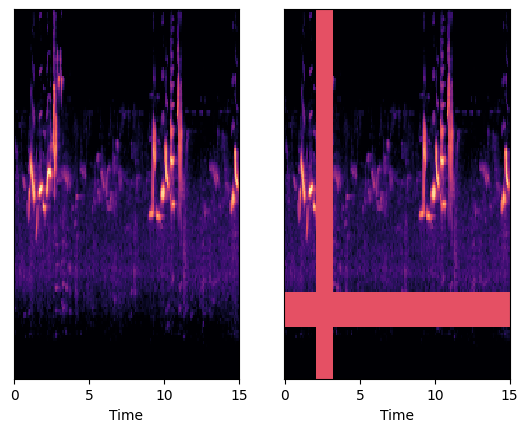

In [37]:
spec = load_random_spec_slice(df, ID = 0)
print(spec.shape)
fig, ax = plt.subplots(1,2)
librosa.display.specshow(spec, sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax[0]);
librosa.display.specshow(tfm_layer(spec.reshape(1, *cfg.input_dim, 1), training = True).numpy().reshape(*cfg.input_dim), 
                         sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax[1]);

In [38]:
def build_model2():
    inp = Input(shape=(*cfg.input_dim, 1))
    
    # Normalize
    x = zscore_layer(inp)
    # Time Frequency masking
    x = tfm_layer(x)
    # Base model
    x = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    x = Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(cfg.n_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=output, name = "Model2")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [39]:
model2 = build_model2()

Model: "Model2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 162, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z_score_min_max (ZScoreMinMax)  │ (None, 128, 162, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_freq_mask (TimeFreqMask)   │ (None, 128, 162, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 126, 160, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 78, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 74880)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     4,792,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,813,610 (18.36 MB)

 Trainable params: 4,813,610 (18.36 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
hist3 = model2.fit(training_generator,
                    validation_data=validation_generator,
                    verbose = 2, epochs = cfg.n_epochs)

Epoch 1/50


W0000 00:00:1720515718.838300   19513 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. while/random_uniform/RandomUniform


6/6 - 10s - 2s/step - accuracy: 0.0469 - loss: 2.4619 - val_accuracy: 0.0938 - val_loss: 2.3234
Epoch 2/50
6/6 - 5s - 876ms/step - accuracy: 0.0938 - loss: 2.2998 - val_accuracy: 0.0781 - val_loss: 2.3039
Epoch 3/50
6/6 - 3s - 515ms/step - accuracy: 0.1302 - loss: 2.3017 - val_accuracy: 0.1250 - val_loss: 2.3032
Epoch 4/50
6/6 - 3s - 509ms/step - accuracy: 0.1250 - loss: 2.2993 - val_accuracy: 0.0625 - val_loss: 2.3035
Epoch 5/50
6/6 - 3s - 494ms/step - accuracy: 0.1250 - loss: 2.2966 - val_accuracy: 0.0312 - val_loss: 2.3178
Epoch 6/50
6/6 - 5s - 905ms/step - accuracy: 0.0938 - loss: 2.2962 - val_accuracy: 0.0469 - val_loss: 2.3146
Epoch 7/50
6/6 - 3s - 499ms/step - accuracy: 0.1354 - loss: 2.2848 - val_accuracy: 0.0625 - val_loss: 2.3105
Epoch 8/50
6/6 - 3s - 498ms/step - accuracy: 0.1250 - loss: 2.2915 - val_accuracy: 0.0469 - val_loss: 2.3217
Epoch 9/50
6/6 - 3s - 500ms/step - accuracy: 0.1458 - loss: 2.2666 - val_accuracy: 0.1250 - val_loss: 2.3007
Epoch 10/50
6/6 - 3s - 510ms/ste